# Prueba del paquete GeoPandas para hacer mapas

* Se usarán datos públicos del vizualizador **IDEcanarias**

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import zipfile
import requests

## Descarga de los datos

* Necesario el archivo en la carpeta ```metadata```: ```metadatos_medio_ambiente.csv``` 

In [3]:
## URLs de los archivos de interés
url_eennpp = "https://opendata.sitcan.es/upload/medio-ambiente/eennpp.zip"
url_islas_generalizadas = "https://opendata.sitcan.es/upload/unidades-administrativas/gobcan_unidades-administrativas_islas-generalizadas.zip"
url_especies_protegidas = "https://opendata.sitcan.es/dataset/69378f67-7787-4921-b432-a410acc92736/resource/1668787f-d6f2-419c-8053-4f83291f21e4/download/especies-protegidas.gpkg"

In [4]:
#################################
##    Descarga de los datos    ##
#################################

directorio_destino = '..\\data'

metadata = pd.read_csv('..\\metadata\\metadatos_medio_ambiente.csv')
directorio_destino = '..\\data'

for url in list(metadata["url"]):
    try:
        # Obtener el nombre del archivo de la URL
        nombre_archivo = os.path.join(directorio_destino, os.path.basename(url))

        # Descargar el archivo
        response = requests.get(url)
        with open(nombre_archivo, 'wb') as file:
            file.write(response.content)

        print(f"Archivo descargado: {nombre_archivo}")

        # Descomprimir el archivo
        with zipfile.ZipFile(nombre_archivo, 'r') as zip_ref:
            zip_ref.extractall(directorio_destino)
            print(f"Archivos descomprimidos en: {directorio_destino}")

    except Exception as e:
        print(f"Error al descargar {url}: {e}")


Archivo descargado: ..\data\eennpp.zip
Archivos descomprimidos en: ..\data
Archivo descargado: ..\data\gobcan_unidades-administrativas_islas-generalizadas.zip
Error al descargar https://opendata.sitcan.es/upload/unidades-administrativas/gobcan_unidades-administrativas_islas-generalizadas.zip: That compression method is not supported
Archivo descargado: ..\data\especies-protegidas.gpkg
Error al descargar https://opendata.sitcan.es/dataset/69378f67-7787-4921-b432-a410acc92736/resource/1668787f-d6f2-419c-8053-4f83291f21e4/download/especies-protegidas.gpkg: File is not a zip file


## Leer los datos SHP

* Se usará la función ```gpd.read_file()```

In [6]:
eennpp = gpd.read_file("..\\data\\eennpp.shp")
islas_canarias = gpd.read_file("..\\data\\islas_generalizadas.shp") 
especies_protegidas = gpd.read_file("..\\data\\especies-protegidas.gpkg")  

In [7]:
eennpp.head()

,codigo,categoria,nombre,geometry
0,H-6,Paisaje Protegido,Ventejís,"POLYGON ((207380.300 3077264.524, 207361.430 3..."
1,H-7,Paisaje Protegido,Timijiraque,"POLYGON ((212318.690 3076408.720, 212322.130 3..."
2,H-3,Reserva Natural Especial,Tibataje,"POLYGON ((205028.180 3074960.459, 205020.849 3..."
3,H-2,Reserva Natural Integral,Roques de Salmor,"MULTIPOLYGON (((205086.150 3081134.320, 205088..."
4,H-5,Monumento Natural,Las Playas,"MULTIPOLYGON (((209998.290 3070692.910, 209998..."


In [8]:
islas_canarias.head()

,nombre,geometry
0,FUERTEVENTURA,"POLYGON ((614400.417 3179644.575, 614046.617 3..."
1,FUERTEVENTURA,"POLYGON ((589085.283 3152305.979, 589312.973 3..."
2,EL HIERRO,"POLYGON ((205260.539 3081076.767, 205665.090 3..."
3,TENERIFE,"POLYGON ((338109.671 3142160.390, 338626.550 3..."
4,LANZAROTE,"POLYGON ((645049.534 3254822.134, 645270.045 3..."


<Axes: >

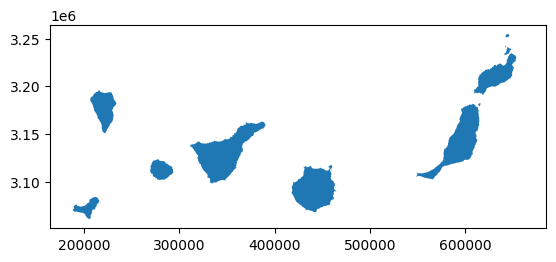

In [9]:
islas_canarias.plot()


In [10]:
especies_protegidas.head()

,isla,riqueza,fila,columna,geometry
0,MA,1,1108,746,"POLYGON ((187500.000 3056000.000, 187500.000 3..."
1,EH,3,1081,747,"POLYGON ((188000.000 3069500.000, 188000.000 3..."
2,EH,1,1080,747,"POLYGON ((188000.000 3070000.000, 188000.000 3..."
3,EH,1,1079,747,"POLYGON ((188000.000 3070500.000, 188000.000 3..."
4,EH,1,1078,747,"POLYGON ((188000.000 3071000.000, 188000.000 3..."


## Preprocesamiento de los datos

In [11]:
filtro_generalizado = islas_canarias["nombre"] == "GRAN CANARIA"
gran_canaria_isla = islas_canarias[filtro_generalizado]
gran_canaria_isla

,nombre,geometry
10,GRAN CANARIA,"POLYGON ((430739.466 3110342.654, 430337.649 3..."


In [12]:
filtro_tafira = eennpp["nombre"] == "Tafira"
eennpp_tafira = eennpp[filtro_tafira]
eennpp_tafira.head()

,codigo,categoria,nombre,geometry
28,C-24,Paisaje Protegido,Tafira,"POLYGON ((455266.194 3104353.840, 455267.026 3..."


In [13]:
filtro_bandama = eennpp["nombre"] == "Bandama"
eennpp_bandama = eennpp[filtro_bandama]
eennpp_bandama.head()

,codigo,categoria,nombre,geometry
36,C-14,Monumento Natural,Bandama,"POLYGON ((454972.768 3102114.880, 454980.146 3..."


In [14]:
especies_protegiodas_tafira = gpd.overlay(especies_protegidas, 
                                          eennpp_tafira, 
                                          how="intersection")
especies_protegiodas_tafira.head()

,isla,riqueza,fila,columna,codigo,categoria,nombre,geometry
0,GC,6,1021,1275,C-24,Paisaje Protegido,Tafira,"POLYGON ((452500.000 3100000.000, 452500.000 3..."
1,GC,1,1020,1275,C-24,Paisaje Protegido,Tafira,"MULTIPOLYGON (((452500.000 3100000.000, 452026..."
2,GC,9,1021,1276,C-24,Paisaje Protegido,Tafira,"POLYGON ((452500.000 3100000.000, 453000.000 3..."
3,GC,2,1017,1276,C-24,Paisaje Protegido,Tafira,"POLYGON ((452500.000 3101659.731, 452512.896 3..."
4,GC,2,1016,1277,C-24,Paisaje Protegido,Tafira,"MULTIPOLYGON (((453500.000 3102000.000, 453237..."


In [15]:
filtro = eennpp["codigo"].str.startswith("C")
eennp_pgran_canaria = eennpp[filtro]
eennp_pgran_canaria.head()

,codigo,categoria,nombre,geometry
20,C-32,Sitio de Interés Científico,Juncalillo del Sur,"POLYGON ((453679.696 3074570.097, 453669.984 3..."
21,C-31,Sitio de Interés Científico,Roque de Gando,"POLYGON ((464665.536 3090497.440, 464658.994 3..."
22,C-30,Sitio de Interés Científico,Tufia,"POLYGON ((462277.610 3093302.880, 462281.280 3..."
23,C-29,Sitio de Interés Científico,Jinámar,"POLYGON ((460256.224 3101297.088, 460260.274 3..."
24,C-28,Paisaje Protegido,Montaña de Agüimes,"POLYGON ((458220.295 3087279.345, 458220.210 3..."


## Visualización de los resulatdos

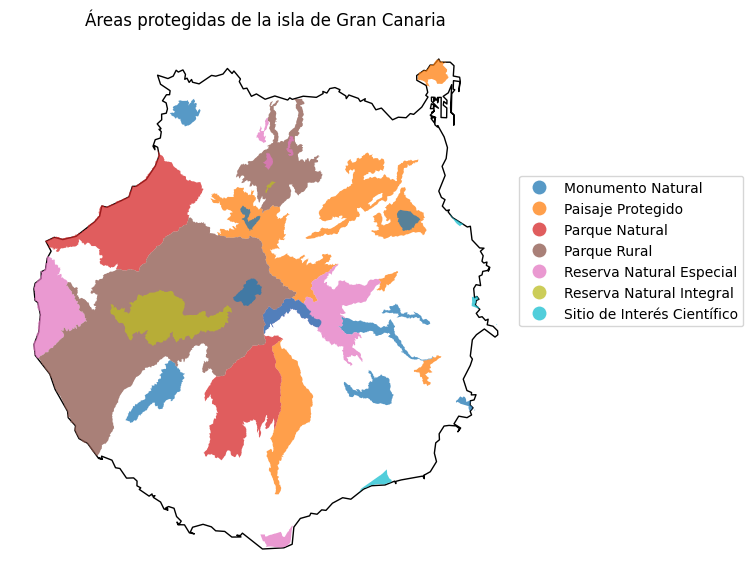

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

gran_canaria_isla.plot(ax=ax, facecolor='white', 
                       edgecolor="black")
plot = eennp_pgran_canaria.plot(column='categoria', 
                                legend=True, 
                                ax=ax,  
                                alpha = .75)
# Set axis labels and title
ax.set_title('Áreas protegidas de la isla de Gran Canaria')
leg = plot.get_legend()
leg.set_bbox_to_anchor((1.45, 0.75))
ax.set_axis_off()


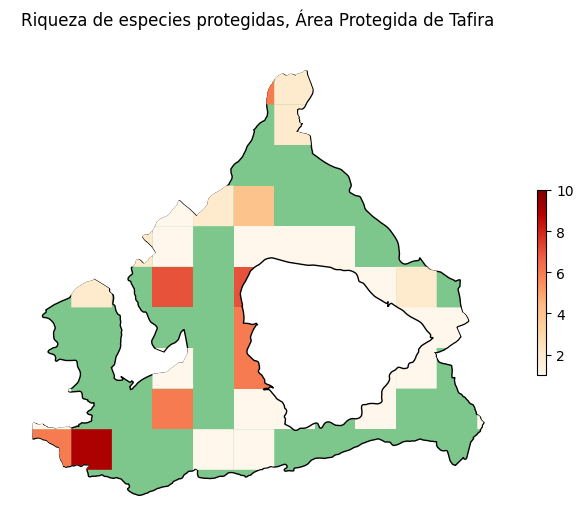

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

eennpp_tafira.plot(ax=ax, 
                   facecolor = "#7dc78c", 
                   edgecolor= "black")
plot = especies_protegiodas_tafira.plot(column="riqueza", 
                                        ax=ax, 
                                        legend=True, 
                                        legend_kwds={'shrink': 0.3}, 
                                        cmap="OrRd")
eennpp_bandama.plot(ax=ax, 
                    facecolor = "white", 
                    edgecolor= "black")

ax.set_title("Riqueza de especies protegidas, Área Protegida de Tafira")
leg = plot.get_legend()
ax.set_axis_off()
